In [1]:
import gc
import sys

import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from stuff.dataset import *
from sklearn.model_selection import train_test_split
import psutil
from memory_profiler import profile

In [2]:
microglia = sc.read_h5ad("../data/ROSMAP/microglia.h5ad")
metadata = pd.read_csv("../data/ROSMAP/ROSMAP_clinical.csv")

C:\Users\limmi\miniconda3\Lib\site-packages\anndata\compat\__init__.py:371: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [22]:
def preprocess(annList, metadata):
    # Process metadata and get mappings

    columns = [
        "individualID", "braaksc", "ceradsc", "cogdx", "msex", "age_at_visit_max", "apoe_genotype", "pmi"
    ]

    # columns2 = [
    #     "individualID", "braaksc", "ceradsc", "age_at_visit_max"
    # ]
    # Select and clean relevant metadata
    metadata_clean = metadata[columns].dropna()

    # drop all the columns were cogdx = 6
    metadata_clean = metadata_clean[metadata_clean["cogdx"] != 6]
    #
    # map the cogdx to an integer value
    metadata_clean["cogdx"] = metadata_clean["cogdx"].astype(int) - 1
    #
    # map the ceradsc to an integer value and minus 1
    metadata_clean["ceradsc"] = metadata_clean["ceradsc"].astype(int) - 1

    metadata_clean["ceradsc"] = 3 - metadata_clean["ceradsc"]
    #
    # take only the samples were pmi < 12 hours
    metadata_clean = metadata_clean[metadata_clean["pmi"] < 12]

    # # bin the braaksc to 4 classes, 0-1-2, 3, 4, 5-6
    metadata_clean["braaksc"] = metadata_clean["braaksc"].replace({0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 3})



    # # Map APOE genotypes to numeric categories
    apoe_map = {
        22.0: 0,
        23.0: 1,
        24.0: 2,
        33.0: 3,
        34.0: 4,
        44.0: 5
    }
    metadata_clean["apoe_genotype"] = metadata_clean["apoe_genotype"].map(apoe_map)
    #
    # replace the 90+ sting values in age_at_visit_max with 90.0
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].replace({"90+": 90.0})
    # replace the strings in age_at_visit_max with their float parsed values
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].astype(float)
    # normalize the age_at_visit_max
    metadata_clean["age_at_visit_max"] = (metadata_clean["age_at_visit_max"] - metadata_clean[
        "age_at_visit_max"].mean()) / metadata_clean["age_at_visit_max"].std()



    for i in annList:
        metadata_clean = metadata_clean[metadata_clean["individualID"].isin(i.obs["individualID"])]

    braak_dict = dict(zip(metadata_clean["individualID"], metadata_clean["braaksc"]))
    cerad_dict = dict(zip(metadata_clean["individualID"], metadata_clean["ceradsc"]))
    cogdx_dict = dict(zip(metadata_clean["individualID"], metadata_clean["cogdx"]))
    sex_dict = dict(zip(metadata_clean["individualID"], metadata_clean["msex"]))
    age_dict = dict(zip(metadata_clean["individualID"], metadata_clean["age_at_visit_max"]))
    apoe_dict = dict(zip(metadata_clean["individualID"], metadata_clean["apoe_genotype"]))

    features = []
    labels = [braak_dict, cerad_dict, cogdx_dict, sex_dict, age_dict, apoe_dict]
    #labels = [braak_dict, cerad_dict, age_dict,]
    datacopies = []
    for data in annList:
        #datacopy = data[data.obs["class"] == 1]
        #datacopy = datacopy[datacopy.obs["state"] == "Mic.2"]

        # limit each braakscore to 5000 samples



        datacopy = data[data.obs["individualID"].isin(metadata_clean["individualID"])]

        #drop all individuals which have 75 or less cells
        counts = datacopy.obs["individualID"].value_counts()
        valid_individuals = counts[counts > 75].index
        datacopy = datacopy[datacopy.obs["individualID"].isin(valid_individuals)]

        # braakData = datacopy.obs["individualID"].map(braak_dict)
        # ceradData = datacopy.obs["individualID"].map(cerad_dict)
        # cogdxData = datacopy.obs["individualID"].map(cogdx_dict)
        # sexData = datacopy.obs["individualID"].map(sex_dict)
        # ageData = datacopy.obs["individualID"].map(age_dict)
        # apoeData = datacopy.obs["individualID"].map(apoe_dict)
        # features = datacopy.X
        datacopies.append(datacopy)

        # labels.append(braakData)
        # labels.append(ceradData)
        # labels.append(cogdxData)
        # labels.append(sexData)
        # labels.append(ageData)
        # labels.append(apoeData)


    return np.array(labels), np.array(features), datacopies

In [23]:
scores, features, datacopies = preprocess([microglia], metadata)

In [25]:
print(microglia)
print(len(microglia.obs["individualID"].unique()))

asd = datacopies[0]
braakDict = scores[0]
ceradDict = scores[1]
cogdxDict = scores[2]
sexDict = scores[3]
ageDict = scores[4]
apoeDict = scores[5]
# get the indivuals from annListUpdated
individuals = asd.obs["individualID"].unique()

# go through the individuals and get the braakscore for each individual
braak_scores = np.array([braakDict[ind] for ind in individuals])
cerad_scores = np.array([ceradDict[ind] for ind in individuals])
cogdx_scores = np.array([cogdxDict[ind] for ind in individuals])


# # print the division of the braakscore
print("Braakscore distribution:")
print(pd.Series(braak_scores).value_counts())
print("Cerad distribution:")
print(pd.Series(cerad_scores).value_counts())
print("Cogdx distribution:")
print(pd.Series(cogdx_scores).value_counts())

print(asd)

AnnData object with n_obs × n_vars = 86612 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
450
Braakscore distribution:
4.0    121
3.0    100
5.0     72
2.0     26
1.0     17
0.0      4
6.0      3
Name: count, dtype: int64
Cerad distribution:
2    125
3     96
0     85
1     37
Name: count, dtype: int64
Cogdx distribution:
0    119
3    114
1     88
4     18
2      4
Name: count, dtype: int64
View of AnnData object with n_obs × n_vars = 71442 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'


In [1]:
dictIds = {'R4119160': {4: 66, 5: 13, 3: 38, 2: 7}, 'R4641987': {4: 73, 3: 89, 2: 16, 5: 6, 1: 2}, 'R7047807': {3: 142, 4: 54, 1: 4, 5: 5, 2: 13}, 'R3579460': {3: 54, 1: 7, 4: 125, 5: 14, 2: 9}, 'R3280186': {3: 101, 2: 7, 4: 43, 5: 2, 1: 3}, 'R7641350': {4: 104, 3: 273, 5: 6, 2: 7, 1: 3}, 'R1710143': {3: 108, 4: 63, 2: 37, 1: 43, 5: 7}, 'R5079327': {4: 199, 2: 57, 3: 128, 1: 13, 5: 4}, 'R4242008': {3: 161, 4: 89, 1: 5, 2: 11, 5: 1}, 'R2645101': {3: 65, 4: 48, 1: 50, 5: 7, 2: 40}, 'R7840275': {3: 113, 4: 102, 5: 30, 2: 23, 1: 3}, 'R8054504': {4: 52, 3: 55, 5: 6, 2: 2, 1: 1}, 'R3442506': {2: 23, 3: 128, 4: 35, 5: 8, 1: 1}, 'R4482444': {4: 57, 3: 47, 2: 7, 5: 11, 1: 1}, 'R6849345': {4: 48, 3: 59, 5: 46, 1: 5, 2: 13}, 'R3857147': {4: 91, 5: 37, 3: 70, 1: 2, 2: 7}, 'R3607578': {3: 156, 2: 14, 4: 86, 5: 8, 1: 3}, 'R7758743': {3: 44, 4: 13, 2: 5, 5: 15}, 'R2575548': {2: 48, 3: 72, 4: 29, 1: 11, 5: 1}, 'R4249236': {3: 70, 4: 94, 2: 10, 5: 9}, 'R3322663': {3: 88, 2: 27, 1: 2, 4: 27, 5: 4}, 'R3825485': {3: 140, 5: 28, 4: 44, 2: 6}, 'R8492506': {4: 135, 5: 22, 3: 78, 2: 4}, 'R7912121': {5: 16, 2: 20, 3: 112, 4: 32, 1: 1}, 'R3035452': {3: 201, 5: 2, 1: 27, 4: 54, 2: 45}, 'R6284240': {4: 49, 3: 105, 1: 5, 2: 21, 5: 8}, 'R9127940': {5: 57, 4: 100, 3: 8}, 'R4292728': {3: 66, 4: 46, 5: 10, 2: 4}, 'R2124216': {4: 138, 3: 103, 5: 43, 1: 3, 2: 11}, 'R8741068': {2: 20, 3: 85, 5: 2, 4: 9, 1: 4}, 'R5789564': {3: 76, 5: 13, 4: 78, 2: 5, 1: 5}, 'R2488731': {2: 44, 3: 152, 4: 149, 5: 31, 1: 5}, 'R6392007': {3: 72, 4: 114, 5: 12, 2: 19}, 'R7944883': {4: 188, 3: 45, 5: 38, 1: 2, 2: 3}, 'R4379962': {5: 13, 4: 18, 3: 5}, 'R5369295': {3: 65, 4: 111, 1: 3, 5: 14, 2: 1}, 'R9936070': {4: 18, 3: 82, 5: 18, 2: 2}, 'R3744330': {5: 18, 3: 56, 4: 83, 1: 7, 2: 13}, 'R6934314': {4: 71, 3: 58, 1: 6, 5: 14, 2: 14}, 'R3631183': {3: 52, 4: 51, 2: 7, 5: 31, 1: 1}, 'R3328867': {4: 16, 3: 69, 2: 35, 1: 6, 5: 2}, 'R1287407': {4: 104, 3: 36, 5: 30, 2: 1, 1: 1}, 'R6268135': {3: 41, 1: 1, 4: 72, 5: 4, 2: 4}, 'R7791442': {3: 74, 4: 128, 2: 2, 5: 4, 1: 1}, 'R3739042': {3: 108, 4: 77, 2: 33, 5: 26, 1: 9}, 'R4602424': {3: 84, 2: 26, 1: 3, 4: 67, 5: 6}, 'R7995082': {4: 108, 5: 31, 3: 55, 2: 11, 1: 3}, 'R7851092': {3: 50, 5: 25, 4: 46, 2: 4}, 'R9354381': {4: 96, 1: 1, 5: 13, 3: 11}, 'R7594705': {5: 20, 4: 46, 3: 12, 2: 1}, 'R4022468': {3: 25, 4: 23, 2: 5, 5: 5, 1: 1}, 'R5656511': {3: 76, 4: 88, 5: 26, 2: 16, 1: 6}, 'R2111091': {4: 49, 5: 8, 3: 23}, 'R5541746': {4: 156, 3: 51, 5: 2, 1: 4, 2: 6}, 'R8155560': {4: 46, 3: 101, 2: 18, 5: 8, 1: 2}, 'R2079629': {4: 102, 3: 52, 2: 9, 5: 1, 1: 1}, 'R2212277': {4: 84, 3: 52, 2: 2, 5: 1}, 'R5447358': {4: 137, 3: 86, 5: 48, 2: 5}, 'R1173111': {4: 81, 3: 41, 2: 8, 5: 25}, 'R8444624': {4: 66, 5: 9, 3: 87, 2: 6}, 'R8553520': {4: 86, 5: 36, 3: 57, 2: 13, 1: 2}, 'R5334541': {5: 16, 2: 14, 4: 122, 3: 79, 1: 4}, 'R6939144': {4: 71, 3: 78, 5: 25, 2: 6}, 'R4276053': {4: 51, 3: 51, 2: 20, 5: 4, 1: 6}, 'R4470253': {3: 87, 4: 52, 5: 22, 2: 7}, 'R2678902': {5: 4, 4: 14, 3: 13, 2: 1, 1: 2}, 'R9680160': {3: 109, 4: 93, 5: 8, 2: 27, 1: 1}, 'R6887989': {4: 47, 3: 86, 2: 13, 5: 4, 1: 3}, 'R6476704': {4: 77, 3: 59, 2: 6, 5: 7, 1: 3}, 'R2398607': {3: 40, 4: 38, 5: 17, 1: 1, 2: 3}, 'R1664857': {3: 20, 4: 111, 5: 28, 2: 1}, 'R4581557': {3: 96, 4: 77, 5: 26, 1: 2, 2: 20}, 'R7438391': {4: 78, 5: 41, 2: 1, 3: 17}, 'R6879714': {2: 17, 4: 47, 3: 72, 5: 10, 1: 3}, 'R6108690': {1: 6, 4: 91, 3: 37, 2: 9, 5: 8}, 'R7959406': {3: 40, 4: 43, 5: 7, 2: 4, 1: 1}, 'R6319811': {4: 80, 3: 83, 2: 18, 1: 9, 5: 9}, 'R3927700': {4: 97, 5: 9, 3: 27, 2: 1}, 'R2347173': {4: 34, 5: 15, 3: 35, 2: 19, 1: 1}, 'R7950545': {4: 147, 3: 14, 2: 3, 5: 6}, 'R9537646': {3: 58, 4: 95, 1: 10, 5: 32, 2: 12}, 'R8410904': {3: 60, 4: 35, 2: 18, 5: 3, 1: 4}, 'R2928383': {3: 76, 4: 68, 5: 7, 2: 8, 1: 1}, 'R8678748': {4: 65, 2: 7, 3: 46, 5: 3, 1: 1}, 'R7651923': {5: 72, 4: 85, 3: 48, 2: 20, 1: 6}, 'R9314674': {4: 43, 5: 45, 2: 6, 3: 19, 1: 1}, 'R2787688': {4: 80, 3: 46, 1: 4, 5: 39, 2: 34}, 'R1133959': {3: 53, 4: 109, 2: 5, 5: 7}, 'R3211474': {4: 78, 2: 3, 5: 16, 3: 27}, 'R5676537': {3: 47, 4: 53, 2: 34, 5: 36, 1: 3}, 'R6679530': {3: 52, 4: 208, 5: 52, 2: 5, 1: 1}, 'R4745715': {3: 24, 4: 48, 5: 10, 2: 5, 1: 2}, 'R6216782': {3: 89, 4: 105, 5: 8, 2: 6, 1: 1}, 'R1234575': {2: 59, 4: 38, 3: 108, 5: 2, 1: 5}, 'R7063792': {4: 122, 5: 25, 3: 19, 1: 1, 2: 2}, 'R1588427': {3: 36, 4: 40, 2: 10, 5: 19, 1: 3}, 'R4012015': {4: 46, 3: 46, 5: 7}, 'R1620679': {2: 14, 3: 82, 4: 49, 5: 12, 1: 2}, 'R5739959': {4: 65, 3: 67, 5: 23, 1: 3, 2: 7}, 'R2393217': {4: 58, 3: 108, 2: 12, 5: 20, 1: 1}, 'R8472815': {5: 10, 4: 193, 3: 12}, 'R2086195': {4: 80, 5: 124, 3: 32, 2: 6, 1: 2}, 'R5061712': {3: 132, 4: 71, 2: 11, 5: 17, 1: 8}, 'R6600608': {2: 17, 3: 72, 4: 34, 5: 39, 1: 1}, 'R8057601': {4: 49, 3: 184, 5: 12, 1: 12, 2: 10}, 'R7029629': {3: 44, 4: 86, 5: 33, 1: 7, 2: 9}, 'R4005989': {4: 83, 5: 29, 3: 16, 2: 6, 1: 1}, 'R4928630': {4: 26, 3: 13, 5: 3, 2: 4, 1: 2}, 'R7506996': {4: 5, 3: 2, 5: 3, 1: 1}, 'R2246117': {4: 147, 5: 26, 3: 13}, 'R4516201': {4: 138, 3: 85, 5: 55, 1: 4, 2: 7}, 'R9938583': {3: 82, 4: 88, 5: 12, 2: 3, 1: 2}}




In [10]:
for i in dictIds.keys():
    correct = metadata[metadata["individualID"] == i]["braaksc"].values[0]
    predsForCorrect = 0
    if correct in dictIds[i].keys():
        predsForCorrect = dictIds[i][int(correct)]
    
    maxScore = 0
    maxBraak = 0
    mean = 0
    total = 0
    for j in range(6):
        if j in dictIds[i].keys():
            if dictIds[i][j] > maxScore:
                maxScore = dictIds[i][j]
                maxBraak = j
            total += dictIds[i][j]
            mean += dictIds[i][j] * j
            
    if total > 0:
        mean /= total
    else:
        mean = 0

    acc = predsForCorrect / total if total > 0 else 0
    otheracc = maxScore / total if total > 0 else 0
    if otheracc > 0.6:
        print(f"ID: {i}, Correct: {correct}, Predicted: {maxBraak}, % of votes: {otheracc*100:>0.1f}%, accuracy for correct braak: {acc*100:>0.1f}%")
    

ID: R7047807, Correct: 1.0, Predicted: 3, % of votes: 65.1%, accuracy for correct braak: 1.8%
ID: R3280186, Correct: 2.0, Predicted: 3, % of votes: 64.7%, accuracy for correct braak: 4.5%
ID: R7641350, Correct: 4.0, Predicted: 3, % of votes: 69.5%, accuracy for correct braak: 26.5%
ID: R4242008, Correct: 3.0, Predicted: 3, % of votes: 60.3%, accuracy for correct braak: 60.3%
ID: R3442506, Correct: 3.0, Predicted: 3, % of votes: 65.6%, accuracy for correct braak: 65.6%
ID: R3825485, Correct: 1.0, Predicted: 3, % of votes: 64.2%, accuracy for correct braak: 0.0%
ID: R7912121, Correct: 4.0, Predicted: 3, % of votes: 61.9%, accuracy for correct braak: 17.7%
ID: R3035452, Correct: 4.0, Predicted: 3, % of votes: 61.1%, accuracy for correct braak: 16.4%
ID: R9127940, Correct: 1.0, Predicted: 4, % of votes: 60.6%, accuracy for correct braak: 0.0%
ID: R8741068, Correct: 1.0, Predicted: 3, % of votes: 70.8%, accuracy for correct braak: 3.3%
ID: R7944883, Correct: 5.0, Predicted: 4, % of votes: 6

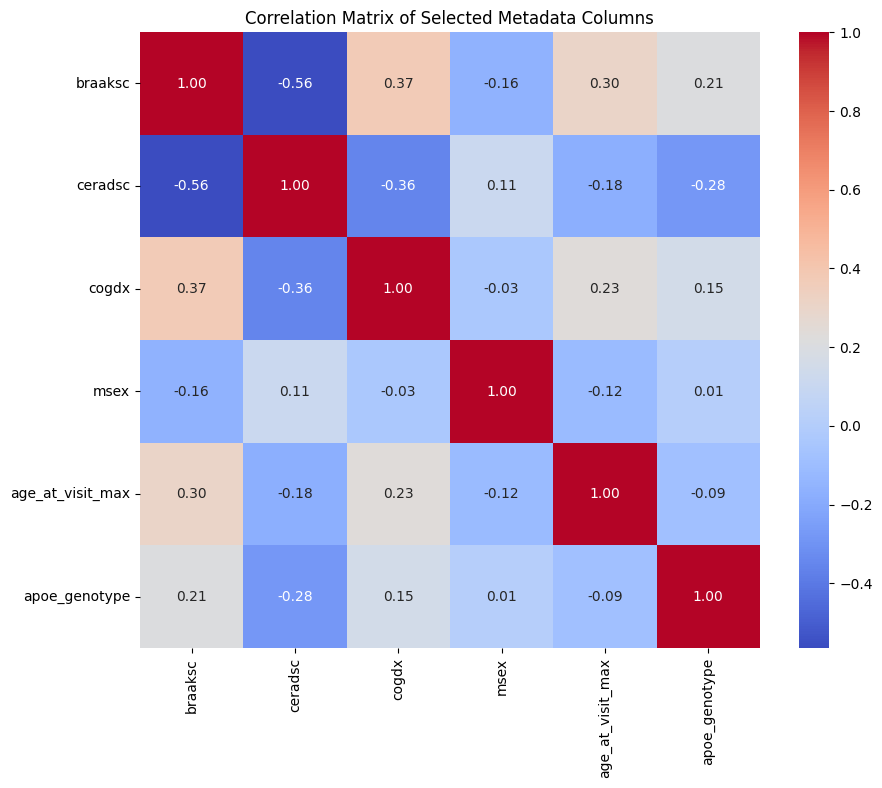

In [18]:
# create a correlation matrix for the following columns in metadata: Braak, CERAD, COGDX, msex, age_at_visit_max, apoe_genotype

columns = ["braaksc", "ceradsc", "cogdx", "msex", "age_at_visit_max", "apoe_genotype"]
metadata_clean = metadata[columns].dropna()

# # Optionally: Convert categorical fields to numeric encodings
# # For example, if apoe_genotype is like '33', '34', '44', you can map them
# df["apoe_genotype"] = df["apoe_genotype"].astype(str).map({'33': 0, '34': 1, '44': 2, '23': 3, '24': 4})
# df["msex"] = df["msex"].map({1: 0, 2: 1})  # if it's 1=male, 2=female

 # drop all the columns were cogdx = 6
metadata_clean = metadata_clean[metadata_clean["cogdx"] != 6]

# map the cogdx to an integer value
metadata_clean["cogdx"] = metadata_clean["cogdx"].astype(int) - 1

metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].replace({"90+": 90.0})
apoe_map = {
        22.0: 0,
        23.0: 1,
        24.0: 2,
        33.0: 3,
        34.0: 4,
        44.0: 5
    }
metadata_clean["apoe_genotype"] = metadata_clean["apoe_genotype"].map(apoe_map)




# Compute the correlation matrix
corr_matrix = metadata_clean.corr()

# Display as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Selected Metadata Columns")
plt.show()


In [3]:
gc.collect()
sc.pp.highly_variable_genes(microglia, n_top_genes=1000, subset=True)

In [4]:
print(microglia)
print(microglia.obs)

AnnData object with n_obs × n_vars = 86612 × 1000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
                                nCount_RNA  nFeature_RNA  nCount_SCT  \
190403-B4-A_AGGGCCTAGGCAGCTA-1      3903.0          2046      3514.0   
190403-B4-A_TTCCAATTCACACCGG-1      3758.0          2136      3512.0   
190403-B4-A_TACTGCCTCAAGCCCG-1      3668.0          1861      3446.0   
190403-B4-A_ATACCTTCATCCGAAT-1      3396.0          2017      3326.0   
190403-B4-A_CATGGTAAGCTCATAC-1      3268.0          1959      3239.0   
...                                    ...           ...         ...   
MAP84653463_CATTGAGAGAGTGAAG-1       685.0           564      2060.0   
MAP84653463_AAAGGGCGTCCATAGT-1       637.0           

In [5]:
def preprocess(annList, metadata):
    # Process metadata and get mappings

    columns = [
        "individualID", "braaksc", "ceradsc", "cogdx", "msex", "age_at_visit_max", "apoe_genotype"
    ]
    # Select and clean relevant metadata
    metadata_clean = metadata[columns].dropna()

    # drop all the columns were cogdx = 6
    metadata_clean = metadata_clean[metadata_clean["cogdx"] != 6]

    # map the cogdx to an integer value
    metadata_clean["cogdx"] = metadata_clean["cogdx"].astype(int) - 1

    # map the ceradsc to an integer value and minus 1
    metadata_clean["ceradsc"] = metadata_clean["ceradsc"].astype(int) - 1



    # Map APOE genotypes to numeric categories
    apoe_map = {
        22.0: 0,
        23.0: 1,
        24.0: 2,
        33.0: 3,
        34.0: 4,
        44.0: 5
    }
    metadata_clean["apoe_genotype"] = metadata_clean["apoe_genotype"].map(apoe_map)

    # replace the 90+ sting values in age_at_visit_max with 90.0
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].replace({"90+": 90.0})
    # replace the strings in age_at_visit_max with their float parsed values
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].astype(float)
    # normalize the age_at_visit_max
    metadata_clean["age_at_visit_max"] = (metadata_clean["age_at_visit_max"] - metadata_clean[
        "age_at_visit_max"].mean()) / metadata_clean["age_at_visit_max"].std()



    for i in annList:
        metadata_clean = metadata_clean[metadata_clean["individualID"].isin(i.obs["individualID"])]

    braak_dict = dict(zip(metadata_clean["individualID"], metadata_clean["braaksc"]))
    cerad_dict = dict(zip(metadata_clean["individualID"], metadata_clean["ceradsc"]))
    cogdx_dict = dict(zip(metadata_clean["individualID"], metadata_clean["cogdx"]))
    sex_dict = dict(zip(metadata_clean["individualID"], metadata_clean["msex"]))
    age_dict = dict(zip(metadata_clean["individualID"], metadata_clean["age_at_visit_max"]))
    apoe_dict = dict(zip(metadata_clean["individualID"], metadata_clean["apoe_genotype"]))

    features = []
    labels = []
    for data in annList:
        datacopy = data[data.obs["class"] == 1]
        #datacopy = datacopy[datacopy.obs["state"] == "Mic.2"]

        # limit each braakscore to 5000 samples



        datacopy = datacopy[datacopy.obs["individualID"].isin(metadata_clean["individualID"])]

        braakData = datacopy.obs["individualID"].map(braak_dict)
        ceradData = datacopy.obs["individualID"].map(cerad_dict)
        cogdxData = datacopy.obs["individualID"].map(cogdx_dict)
        sexData = datacopy.obs["individualID"].map(sex_dict)
        ageData = datacopy.obs["individualID"].map(age_dict)
        apoeData = datacopy.obs["individualID"].map(apoe_dict)
        features = datacopy.X

        labels.append(braakData)
        labels.append(ceradData)
        labels.append(cogdxData)
        labels.append(sexData)
        labels.append(ageData)
        labels.append(apoeData)


    return np.array(labels), np.array(features)

In [6]:
annList = [microglia]

scores, features = preprocess(annList, metadata)

# Convert to PyTorch tensors
X = features
yBraak = scores[0].astype(int)

In [7]:
print(X.shape)
print(yBraak.shape)

(79881, 1000)
(79881,)


In [14]:
from sklearn.model_selection import train_test_split
# Perform a single 80/20 split
X_train, X_test, y_trainBraak, y_testBraak = train_test_split(
    X, yBraak, test_size=0.2, random_state=10, stratify=yBraak
)

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_trainBraak, return_counts=True))
print(np.unique(y_testBraak, return_counts=True))

(63904, 1000)
(15977, 1000)
(array([0, 1, 2, 3, 4, 5, 6]), array([  737,  3153,  4722, 18114, 22810, 13699,   669], dtype=int64))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 184,  788, 1181, 4529, 5703, 3425,  167], dtype=int64))


In [4]:
print(microglia.obs["class"].unique())
print(microglia.obs["state"].unique())

# select all the rows where state is Mic.1
print(microglia[microglia.obs["class"] == 0].obs["state"].unique())

# print the  number of cells in each state
print(microglia.obs["state"].value_counts())


[1 0]
['Mic.1' 'Mic.13' 'Mic.7' 'Mic.12' 'Mic.10' 'Mic.8' 'Mic.6' 'Mic.9'
 'Mic.2' 'Mic.4' 'Mic.3' 'Macrophages' 'Mic.16' 'Monocytes' 'Mic.5'
 'Mic.15' 'Mic.14' 'Mic.11']
['Macrophages' 'Monocytes']
state
Mic.2          13720
Mic.7          12865
Mic.5          10465
Mic.3           8333
Mic.6           7913
Mic.8           5743
Mic.4           4906
Mic.12          3881
Mic.10          3634
Mic.9           3538
Mic.13          2683
Macrophages     2070
Mic.15          1901
Mic.1           1307
Mic.11          1029
Mic.16           952
Mic.14           859
Monocytes        813
Name: count, dtype: int64


In [ ]:
# remove the cells in microglia with less than 200 genes expressed
microglia = microglia[microglia.obs["n_genes"] > 200]

In [4]:
states = microglia.obs["state"].values
# Convert the states to one-hot encoding
stateDict = {
    "Mic.1": 0,
    "Mic.2": 1,
    "Mic.3": 2,
    "Mic.4": 3,
    "Mic.5": 4,
    "Mic.6": 5,
    "Mic.7": 6,
    "Mic.8": 7,
    "Mic.9": 8,
    "Mic.10": 9,
    "Mic.11": 10,
    "Mic.12": 11,
    "Mic.13": 12,
    "Mic.14": 13,
    "Mic.15": 14,
    "Mic.16": 15,
    "Macrophages" : 16,
    "Monocytes" : 17
}

# map the states to their corresponding values
# One-hot encode state labels
state_ints = microglia.obs["state"].map(stateDict)
states_one_hot = pd.get_dummies(state_ints, dtype=int)

# Ensure all expected state columns are present
for i in range(len(stateDict)):
    if i not in states_one_hot.columns:
        states_one_hot[i] = 0
states_one_hot = states_one_hot.sort_index(axis=1)
    

    

In [5]:
print(states_one_hot.values)

[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]]


In [24]:
gc.collect()

1679

In [11]:
columns = ["individualID", "braaksc", "ceradsc", "cogdx"]
asd = metadata[columns].dropna()
print(asd)

#counts the non-nan values for braaksc, ceradsc, and cogdx
print("braaksc", asd["braaksc"].notna().sum())
print("ceradsc", asd["ceradsc"].notna().sum())
print("cogdx", asd["cogdx"].notna().sum())

#count the non-nan values where none of the three columns is nan
print("none nan", asd[asd["braaksc"].notna() & asd["ceradsc"].notna() & asd["cogdx"].notna()].shape[0])

     individualID  braaksc  ceradsc  cogdx
0        R6939144      4.0      2.0    4.0
1        R3893503      4.0      2.0    4.0
2        R8937093      3.0      2.0    4.0
5        R4859661      3.0      4.0    4.0
6        R1954385      4.0      1.0    4.0
...           ...      ...      ...    ...
3531     R4723846      0.0      4.0    1.0
3539     R4690908      2.0      4.0    1.0
3543     R7378741      0.0      4.0    2.0
3553     R3045685      2.0      2.0    5.0
3567     R6291376      1.0      1.0    1.0

[1596 rows x 4 columns]
braaksc 1596
ceradsc 1596
cogdx 1596
none nan 1596


In [4]:
sc.pp.highly_variable_genes(microglia, n_top_genes=500, subset=True)

In [5]:
print(microglia)

AnnData object with n_obs × n_vars = 86612 × 500
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'


In [8]:
annList = [microglia]
def processMetadata(metadata, annList):
    # List of columns to extract
    # columns = [
    #     "individualID", "braaksc", "age_at_visit_max", "race", "msex",
    #     "educ", "cogdx", "ceradsc", "spanish", "apoe_genotype"
    # ]

    columns = [
        "individualID", "braaksc", "age_at_visit_max", "race", "msex",
        "educ", "spanish", "apoe_genotype"
    ]
    # Select and clean relevant metadata
    metadata_clean = metadata[columns].dropna()

    for i in annList:
        metadata_clean = metadata_clean[metadata_clean["individualID"].isin(i.obs["individualID"])]

    # Map APOE genotypes to numeric categories
    apoe_map = {
        22.0: 1.0,
        23.0: 2.0,
        24.0: 3.0,
        33.0: 4.0,
        34.0: 5.0,
        44.0: 6.0
    }
    metadata_clean["apoe_genotype"] = metadata_clean["apoe_genotype"].map(apoe_map)

    # replace the 90+ sting values in age_at_visit_max with 90.0
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].replace({"90+": 90.0})
    # replace the strings in age_at_visit_max with their float parsed values
    metadata_clean["age_at_visit_max"] = metadata_clean["age_at_visit_max"].astype(float)

    # normalize the age_at_visit_max
    metadata_clean["age_at_visit_max"] = (metadata_clean["age_at_visit_max"] - metadata_clean[
        "age_at_visit_max"].mean()) / metadata_clean["age_at_visit_max"].std()

    # normalize the educ
    metadata_clean["educ"] = (metadata_clean["educ"] - metadata_clean["educ"].mean()) / metadata_clean["educ"].std()

    # Create lookup dictionaries
    braak_dict = dict(zip(metadata_clean["individualID"], metadata_clean["braaksc"]))
    # extra_dict = metadata_clean.set_index("individualID")[
    #     ["age_at_visit_max", "race", "msex", "educ", "cogdx", "ceradsc", "spanish", "apoe_genotype"]
    # ].to_dict(orient="index")

    extra_dict = metadata_clean.set_index("individualID")[
        ["age_at_visit_max", "race", "msex", "educ", "spanish", "apoe_genotype"]
    ].to_dict(orient="index")

    return extra_dict, braak_dict, metadata_clean

In [11]:
extra_dict, braak_dict, metadata_clean = processMetadata(metadata, annList)
features = []
additional_inputs = []
labels = []

for donor_id in metadata_clean["individualID"]:
    donor_cells = []

    # Collect all cells from this donor across all AnnData objects
    for data in annList:
        donor_cells.append(data[data.obs["individualID"] == donor_id].X)

    donor_data = donor_cells[0]
    for i in range(1, len(donor_cells)):
        donor_data = np.concatenate((donor_data, donor_cells[i]), axis=0)

    avg_pca = np.mean(donor_data, axis=0)

    # Get metadata features and braak class
    donor_meta = list(extra_dict[donor_id].values())
    braak_class = braak_dict[donor_id]

    features.append(avg_pca)
    additional_inputs.append(donor_meta)
    labels.append(braak_class)

In [14]:
print(len(features[0]))

500


In [64]:
print(microglia)

#select and print all rows where the individualID is R6939144

print(metadata[metadata['individualID'] == 'R9314674'].shape)
print(microglia.obs["individualID"].unique())
print(microglia[microglia.obs['individualID'] == 'R9314674'].obs["batch"].unique())
print(microglia[microglia.obs['individualID'] == 'R9314674'].shape)

columns = [
    "individualID", "braaksc"
]
# Select and clean relevant metadata
metadata_clean = metadata[columns].dropna()
metadata_clean = metadata_clean[metadata_clean["individualID"].isin(microglia.obs["individualID"])]
pcas = []
ids = []
bs = []

for (i, j) in zip(metadata_clean['individualID'], metadata_clean['braaksc']):
    if i in microglia.obs['individualID'].unique():
        PCA_ind = microglia[microglia.obs['individualID'] == i].obsm['X_pca']
        average = np.mean(PCA_ind, axis=0)
        
        # add the id to the dataframe
        pcas.append(average)
        ids.append(i)
        bs.append(j)
        
        


AnnData object with n_obs × n_vars = 86612 × 4000
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'batch', 'individualID', 'DoubletFinder.score', 'subset', 'class', 'state'
    var: 'features'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances'
(1, 18)
['R4119160' 'R4641987' 'R5693901' 'R9116123' 'R2670295' 'R6759986'
 'R7047807' 'R1743384' 'R3741788' 'R3579460' 'R3844037' 'R3280186'
 'R2979477' 'R9088015' 'R5636935' 'R9101940' 'R6622577' 'R7641350'
 'R1969233' 'R7090624' 'R4078277' 'R1710143' 'R4388056' 'R6911631'
 'R5079327' 'R2197944' 'R7767837' 'R2543886' 'R8998310' 'R1042011'
 'R9210731' 'R6132310' 'R4242008' 'R6352950' 'R9163526' 'R9101835'
 'R6627307' 'R4174623' 'R4087581' 'R2645101' 'R3452739' 'R5415701'
 'R9582641' 'R8075334' 'R3257830' 'R8635714' 'R6249698' 'R7347788'
 'R1214999' 'R9818080' 'R7840275' 'R8054504' 'R3442506' 'R7698313'
 'R2582129' 'R3769291' 'R4087141' 'R7462671' 'R4482444' 'R6849345'
 'R6176158' 'R1830086

In [65]:
df = pd.DataFrame(pcas)
print(df)

#print any nan values in the dataframe
print(bs)


            0         1         2         3         4         5         6   \
0    -4.260386  0.832574  1.647873  3.859558 -0.452847 -1.712472  1.730180   
1    -0.947047  0.099701  0.222596  0.612581  0.133167 -0.457423  0.786232   
2    -0.387703  0.658618 -0.225481  1.714644 -1.560933 -2.097251 -3.053012   
3    -2.322881  0.335510  0.698075 -0.748005  0.970809  3.303566 -4.373915   
4     7.932426  2.715324 -6.321774 -5.469037  0.026643 -4.738773 -0.669025   
..         ...       ...       ...       ...       ...       ...       ...   
443  -3.990552 -0.373532 -0.144080  4.088949 -1.483222 -0.679540  1.968839   
444   2.254619  1.039195  0.443318  2.429324  1.310537 -0.537266  0.002143   
445  10.405436 -0.519492  0.196283 -0.083909  3.521924  1.413786 -0.467584   
446  -6.049952  0.477892  3.138321  3.768656 -0.242986 -1.876948  3.331309   
447  -5.683374  0.976284  0.102481  3.543672 -0.803482 -0.304049  4.568402   

           7         8         9   ...        40        41     

In [66]:
class NeuralNetwork4Hidden(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(50, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(), y).item()

    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")
    return test_loss

In [74]:
X = torch.tensor(df.values, dtype=torch.float32)
y = torch.tensor(bs, dtype=torch.float32)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
# create the train and test dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model4hidden = NeuralNetwork4Hidden()
print(model4hidden)

optimizer4hidden = torch.optim.Adam(model4hidden.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

NeuralNetwork4Hidden(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=1, bias=True)
  )
)


C:\Users\limmi\AppData\Local\Temp\ipykernel_23168\3055639199.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
C:\Users\limmi\AppData\Local\Temp\ipykernel_23168\3055639199.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))


Epoch 1
-------------------------------
Avg loss: 9.694530 

Epoch 2
-------------------------------
Avg loss: 4.947188 

Epoch 3
-------------------------------
Avg loss: 6.056182 

Epoch 4
-------------------------------
Avg loss: 3.233386 

Epoch 5
-------------------------------
Avg loss: 2.709065 

Epoch 6
-------------------------------
Avg loss: 2.469606 

Epoch 7
-------------------------------
Avg loss: 2.415427 

Epoch 8
-------------------------------
Avg loss: 2.039945 

Epoch 9
-------------------------------
Avg loss: 1.953863 

Epoch 10
-------------------------------
Avg loss: 1.965357 

Epoch 11
-------------------------------
Avg loss: 1.901107 

Epoch 12
-------------------------------
Avg loss: 1.856692 

Epoch 13
-------------------------------
Avg loss: 1.883746 

Epoch 14
-------------------------------
Avg loss: 1.844638 

Epoch 15
-------------------------------
Avg loss: 1.916719 

Epoch 16
-------------------------------
Avg loss: 1.871987 

Epoch 17
--------

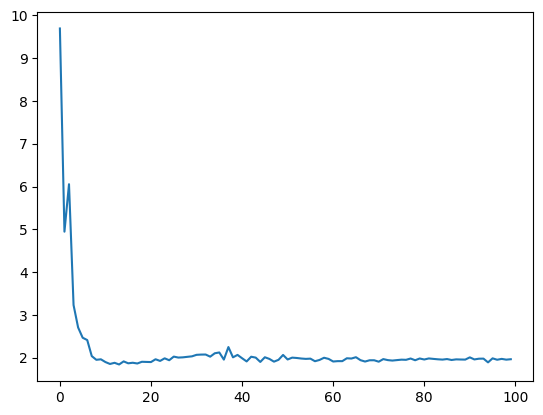

In [75]:
losses = []
epochs = 100
for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_loader, model4hidden, loss_fn, optimizer4hidden)
    losses.append(test(test_loader, model4hidden, loss_fn))
print("Done!")
print(losses)

import matplotlib.pyplot as plt
plt.plot(losses)